In [1]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from networks import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,f1_score,multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau,OneCycleLR
import torch
from torch.nn.utils import clip_grad_norm_
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import BCELoss
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
emb = pd.read_pickle(os.path.join(Path.cwd().parent,'data','stackexchange_reduced_tags_embeddings.pkl'))

In [4]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(emb['tags'])

In [5]:
title_embeddings = np.vstack(emb['title_embedding'].values)
body_embeddings = np.vstack(emb['question_text_embedding'].values)
num_tags = emb['tags'].apply(len).values.reshape(-1)
indices = emb.index.tolist()

In [6]:
train_dataset = StackOverflowDataset(
    title_embeddings=title_embeddings,
    body_embeddings=body_embeddings,
    num_tags_list=num_tags,
    binary_labels=y,
    train=True,
)
val_dataset = StackOverflowDataset(
    title_embeddings=title_embeddings,
    body_embeddings=body_embeddings,
    num_tags_list=num_tags,
    binary_labels=y,
    train=False,
)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
num_epochs = 100
COOLDOWN_START = 20 # Curriculum learning param
model = DSF_CrossAttn_Classifier().to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, 
                                          steps_per_epoch=len(train_loader), 
                                          epochs=num_epochs+1,pct_start=0.3)
criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=1)

In [9]:
def set_model_dropout(model, drop_rate):
    for _, module in model.named_modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = drop_rate

In [10]:
def mixup_data(t_emb, b_emb, n_tags, y, alpha=0.4):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = t_emb.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_t = lam * t_emb + (1 - lam) * t_emb[index, :]
    mixed_b = lam * b_emb + (1 - lam) * b_emb[index, :]
    mixed_n = lam * n_tags + (1 - lam) * n_tags[index, :]
    
    y_a, y_b = y, y[index, :]
    return mixed_t, mixed_b, mixed_n, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def optimize_threshold(probs, targets):
    best_t = 0.5
    best_f1 = 0.0
    
    # Search thresholds from 0.1 to 0.9
    for t in np.arange(0.1, 0.9, 0.05):
        preds = (probs > t).astype(int)
        f1 = f1_score(targets, preds, average='micro')
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    if epoch == COOLDOWN_START:
        print("\n>>> STARTING COOLDOWN PHASE: Mixup OFF, Dropout -> 0.25 <<<")
        set_model_dropout(model, 0.25)
    use_mixup = (epoch < COOLDOWN_START)
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

    for t_emb, b_emb, n_tags, labels in train_bar:
        t_emb, b_emb = t_emb.to(device), b_emb.to(device)
        n_tags, labels = n_tags.to(device), labels.to(device)

        optimizer.zero_grad()

        if use_mixup:        
            inputs_t, inputs_b, inputs_n, targets_a, targets_b, lam = mixup_data(t_emb, b_emb, n_tags, labels, alpha=0.2)
            logits = model(inputs_t, inputs_b, inputs_n)
            loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)
        else:
            logits = model(t_emb, b_emb, n_tags)
            loss = criterion(logits, labels)
        
        
        loss.backward()
        
        clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step() # Step scheduler every batch for OneCycle
        
        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
        
    avg_train_loss = running_loss / len(train_loader)
    
    # --- Validation ---
    model.eval()
    val_targets = []
    val_preds = []
    
    with torch.no_grad():
        for t_emb, b_emb, n_tags, labels in val_loader:
            t_emb = t_emb.to(device)
            b_emb = b_emb.to(device)
            n_tags = n_tags.to(device)
            labels = labels.cpu().numpy()
            
            logits = model(t_emb, b_emb, n_tags)
            
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            
            val_targets.append(labels)
            val_preds.append(preds)
            
    # Concatenate all batches
    val_targets = np.vstack(val_targets)
    val_preds = np.vstack(val_preds)

    best_threshold, best_val_f1 = optimize_threshold(val_preds, val_targets)
    
    # Calculate F1 Score (Micro is usually preferred for global performance)
    val_f1_micro = f1_score(val_targets, val_preds, average='micro')
    val_f1_macro = f1_score(val_targets, val_preds, average='macro')
    
    print(f"Epoch {epoch+1} Results:")
    print(f"Optimal Threshold: {best_threshold:.2f} -> New Val F1: {best_val_f1:.4f}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val F1 (Micro): {val_f1_micro:.4f}")
    print(f"  Val F1 (Macro): {val_f1_macro:.4f}")
    
    scheduler.step()


Epoch 1/100 [Train]: 100%|██████████| 2657/2657 [00:31<00:00, 83.39it/s, loss=6.86]


Epoch 1 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6394
  Train Loss: 76.8615
  Val F1 (Micro): 0.6394
  Val F1 (Macro): 0.5994


Epoch 2/100 [Train]: 100%|██████████| 2657/2657 [00:29<00:00, 91.61it/s, loss=4.64]


Epoch 2 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6623
  Train Loss: 57.1376
  Val F1 (Micro): 0.6623
  Val F1 (Macro): 0.6295


Epoch 3/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 91.99it/s, loss=4.2] 


Epoch 3 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6784
  Train Loss: 53.5730
  Val F1 (Micro): 0.6784
  Val F1 (Macro): 0.6476


Epoch 4/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.69it/s, loss=4.49]


Epoch 4 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6902
  Train Loss: 51.9950
  Val F1 (Micro): 0.6902
  Val F1 (Macro): 0.6588


Epoch 5/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.85it/s, loss=3.66]


Epoch 5 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6987
  Train Loss: 50.9044
  Val F1 (Micro): 0.6987
  Val F1 (Macro): 0.6666


Epoch 6/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.72it/s, loss=3.43]


Epoch 6 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6979
  Train Loss: 49.7528
  Val F1 (Micro): 0.6979
  Val F1 (Macro): 0.6691


Epoch 7/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.83it/s, loss=5.06]


Epoch 7 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7042
  Train Loss: 49.2149
  Val F1 (Micro): 0.7042
  Val F1 (Macro): 0.6716


Epoch 8/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.40it/s, loss=3.49]


Epoch 8 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7052
  Train Loss: 49.0016
  Val F1 (Micro): 0.7052
  Val F1 (Macro): 0.6754


Epoch 9/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 93.23it/s, loss=6.98]


Epoch 9 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7080
  Train Loss: 49.0915
  Val F1 (Micro): 0.7080
  Val F1 (Macro): 0.6788


Epoch 10/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 93.17it/s, loss=5.64]


Epoch 10 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7067
  Train Loss: 48.9436
  Val F1 (Micro): 0.7067
  Val F1 (Macro): 0.6804


Epoch 11/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.80it/s, loss=1.4] 


Epoch 11 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7086
  Train Loss: 48.9083
  Val F1 (Micro): 0.7086
  Val F1 (Macro): 0.6815


Epoch 12/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.94it/s, loss=2.16]


Epoch 12 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7043
  Train Loss: 48.7663
  Val F1 (Micro): 0.7043
  Val F1 (Macro): 0.6821


Epoch 13/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.94it/s, loss=15.3]


Epoch 13 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7086
  Train Loss: 48.7766
  Val F1 (Micro): 0.7086
  Val F1 (Macro): 0.6801


Epoch 14/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.44it/s, loss=2.44]


Epoch 14 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7038
  Train Loss: 48.7353
  Val F1 (Micro): 0.7038
  Val F1 (Macro): 0.6790


Epoch 15/100 [Train]: 100%|██████████| 2657/2657 [00:29<00:00, 91.58it/s, loss=1.8] 


Epoch 15 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7066
  Train Loss: 49.1395
  Val F1 (Micro): 0.7066
  Val F1 (Macro): 0.6802


Epoch 16/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.92it/s, loss=5.22]


Epoch 16 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7071
  Train Loss: 47.9664
  Val F1 (Micro): 0.7071
  Val F1 (Macro): 0.6762


Epoch 17/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 93.16it/s, loss=6.9] 


Epoch 17 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7011
  Train Loss: 48.4246
  Val F1 (Micro): 0.7011
  Val F1 (Macro): 0.6799


Epoch 18/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 93.16it/s, loss=3.88]


Epoch 18 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7030
  Train Loss: 48.2275
  Val F1 (Micro): 0.7030
  Val F1 (Macro): 0.6777


Epoch 19/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.65it/s, loss=8.16]


Epoch 19 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7022
  Train Loss: 48.4478
  Val F1 (Micro): 0.7022
  Val F1 (Macro): 0.6778


Epoch 20/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.26it/s, loss=2.71]


Epoch 20 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7058
  Train Loss: 47.7222
  Val F1 (Micro): 0.7058
  Val F1 (Macro): 0.6775

>>> STARTING COOLDOWN PHASE: Mixup OFF, Dropout -> 0.25 <<<


Epoch 21/100 [Train]: 100%|██████████| 2657/2657 [00:27<00:00, 97.71it/s, loss=1.8] 


Epoch 21 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6983
  Train Loss: 32.6594
  Val F1 (Micro): 0.6983
  Val F1 (Macro): 0.6801


Epoch 22/100 [Train]: 100%|██████████| 2657/2657 [00:27<00:00, 97.39it/s, loss=6.7]  


Epoch 22 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7068
  Train Loss: 30.5029
  Val F1 (Micro): 0.7068
  Val F1 (Macro): 0.6831


Epoch 23/100 [Train]: 100%|██████████| 2657/2657 [00:27<00:00, 96.28it/s, loss=1.26]


Epoch 23 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6999
  Train Loss: 28.6739
  Val F1 (Micro): 0.6999
  Val F1 (Macro): 0.6762


Epoch 24/100 [Train]: 100%|██████████| 2657/2657 [00:27<00:00, 97.07it/s, loss=8.25] 


Epoch 24 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6989
  Train Loss: 27.0214
  Val F1 (Micro): 0.6989
  Val F1 (Macro): 0.6772


Epoch 25/100 [Train]: 100%|██████████| 2657/2657 [00:27<00:00, 97.25it/s, loss=8.75] 


Epoch 25 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7001
  Train Loss: 25.5664
  Val F1 (Micro): 0.7001
  Val F1 (Macro): 0.6760


Epoch 26/100 [Train]: 100%|██████████| 2657/2657 [00:27<00:00, 96.99it/s, loss=9.05]


Epoch 26 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7013
  Train Loss: 24.1784
  Val F1 (Micro): 0.7013
  Val F1 (Macro): 0.6790


Epoch 27/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 98.74it/s, loss=13.3] 


Epoch 27 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7009
  Train Loss: 22.8623
  Val F1 (Micro): 0.7009
  Val F1 (Macro): 0.6791


Epoch 28/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 100.24it/s, loss=8.97]


Epoch 28 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6959
  Train Loss: 21.7468
  Val F1 (Micro): 0.6959
  Val F1 (Macro): 0.6703


Epoch 29/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 102.16it/s, loss=3.54]


Epoch 29 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6935
  Train Loss: 20.7200
  Val F1 (Micro): 0.6935
  Val F1 (Macro): 0.6733


Epoch 30/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 101.11it/s, loss=13.3]


Epoch 30 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6929
  Train Loss: 19.6954
  Val F1 (Micro): 0.6929
  Val F1 (Macro): 0.6741


Epoch 31/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 101.16it/s, loss=14.4]


Epoch 31 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7012
  Train Loss: 18.8322
  Val F1 (Micro): 0.7012
  Val F1 (Macro): 0.6744


Epoch 32/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 100.71it/s, loss=9.87]


Epoch 32 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6959
  Train Loss: 18.0385
  Val F1 (Micro): 0.6959
  Val F1 (Macro): 0.6746


Epoch 33/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 101.32it/s, loss=6.17]


Epoch 33 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6881
  Train Loss: 17.1762
  Val F1 (Micro): 0.6881
  Val F1 (Macro): 0.6703


Epoch 34/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 101.29it/s, loss=9.65]


Epoch 34 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6926
  Train Loss: 16.3943
  Val F1 (Micro): 0.6926
  Val F1 (Macro): 0.6724


Epoch 35/100 [Train]: 100%|██████████| 2657/2657 [00:25<00:00, 102.80it/s, loss=2.12]


Epoch 35 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6910
  Train Loss: 15.8606
  Val F1 (Micro): 0.6910
  Val F1 (Macro): 0.6757


Epoch 36/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 100.70it/s, loss=24.2]


Epoch 36 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7034
  Train Loss: 15.2190
  Val F1 (Micro): 0.7034
  Val F1 (Macro): 0.6838


Epoch 37/100 [Train]: 100%|██████████| 2657/2657 [00:25<00:00, 102.81it/s, loss=6.61]


Epoch 37 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6920
  Train Loss: 14.7240
  Val F1 (Micro): 0.6920
  Val F1 (Macro): 0.6758


Epoch 38/100 [Train]: 100%|██████████| 2657/2657 [00:24<00:00, 107.68it/s, loss=13.2]


Epoch 38 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6988
  Train Loss: 14.0937
  Val F1 (Micro): 0.6988
  Val F1 (Macro): 0.6752


Epoch 39/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.49it/s, loss=8.75]


Epoch 39 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6913
  Train Loss: 13.7006
  Val F1 (Micro): 0.6913
  Val F1 (Macro): 0.6752


Epoch 40/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.78it/s, loss=12.2]


Epoch 40 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6935
  Train Loss: 13.2587
  Val F1 (Micro): 0.6935
  Val F1 (Macro): 0.6760


Epoch 41/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.69it/s, loss=8.72]


Epoch 41 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6985
  Train Loss: 12.7680
  Val F1 (Micro): 0.6985
  Val F1 (Macro): 0.6762


Epoch 42/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.12it/s, loss=11.9]


Epoch 42 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6979
  Train Loss: 12.3632
  Val F1 (Micro): 0.6979
  Val F1 (Macro): 0.6754


Epoch 43/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.49it/s, loss=12.8]


Epoch 43 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6961
  Train Loss: 12.0221
  Val F1 (Micro): 0.6961
  Val F1 (Macro): 0.6765


Epoch 44/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.80it/s, loss=15.2]


Epoch 44 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6998
  Train Loss: 11.6059
  Val F1 (Micro): 0.6998
  Val F1 (Macro): 0.6778


Epoch 45/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.76it/s, loss=16.4]


Epoch 45 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6959
  Train Loss: 11.3113
  Val F1 (Micro): 0.6959
  Val F1 (Macro): 0.6724


Epoch 46/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.56it/s, loss=14.1]


Epoch 46 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6974
  Train Loss: 10.9478
  Val F1 (Micro): 0.6974
  Val F1 (Macro): 0.6766


Epoch 47/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.15it/s, loss=11.9]


Epoch 47 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6962
  Train Loss: 10.5950
  Val F1 (Micro): 0.6962
  Val F1 (Macro): 0.6761


Epoch 48/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.46it/s, loss=11.2]


Epoch 48 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6985
  Train Loss: 10.2317
  Val F1 (Micro): 0.6985
  Val F1 (Macro): 0.6779


Epoch 49/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.05it/s, loss=6.87]


Epoch 49 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7004
  Train Loss: 9.9698
  Val F1 (Micro): 0.7004
  Val F1 (Macro): 0.6781


Epoch 50/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 113.00it/s, loss=10.5]


Epoch 50 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7026
  Train Loss: 9.6540
  Val F1 (Micro): 0.7026
  Val F1 (Macro): 0.6820


Epoch 51/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.07it/s, loss=23.2]


Epoch 51 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7059
  Train Loss: 9.3814
  Val F1 (Micro): 0.7059
  Val F1 (Macro): 0.6836


Epoch 52/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.55it/s, loss=2.54]


Epoch 52 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6999
  Train Loss: 9.0411
  Val F1 (Micro): 0.6999
  Val F1 (Macro): 0.6773


Epoch 53/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.74it/s, loss=21.2]


Epoch 53 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7006
  Train Loss: 8.8161
  Val F1 (Micro): 0.7006
  Val F1 (Macro): 0.6780


Epoch 54/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.44it/s, loss=4.18]


Epoch 54 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.6996
  Train Loss: 8.4495
  Val F1 (Micro): 0.6996
  Val F1 (Macro): 0.6752


Epoch 55/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.00it/s, loss=9.69]


Epoch 55 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7037
  Train Loss: 8.1797
  Val F1 (Micro): 0.7037
  Val F1 (Macro): 0.6789


Epoch 56/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.95it/s, loss=7.93]


Epoch 56 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7040
  Train Loss: 7.9619
  Val F1 (Micro): 0.7040
  Val F1 (Macro): 0.6818


Epoch 57/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.48it/s, loss=6.77]


Epoch 57 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7042
  Train Loss: 7.6437
  Val F1 (Micro): 0.7042
  Val F1 (Macro): 0.6831


Epoch 58/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.17it/s, loss=7.26]


Epoch 58 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7006
  Train Loss: 7.3811
  Val F1 (Micro): 0.7006
  Val F1 (Macro): 0.6800


Epoch 59/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 113.00it/s, loss=9.89]


Epoch 59 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7043
  Train Loss: 7.1305
  Val F1 (Micro): 0.7043
  Val F1 (Macro): 0.6831


Epoch 60/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.36it/s, loss=8.98]


Epoch 60 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7054
  Train Loss: 6.8088
  Val F1 (Micro): 0.7054
  Val F1 (Macro): 0.6822


Epoch 61/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.38it/s, loss=13.7]


Epoch 61 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7102
  Train Loss: 6.5769
  Val F1 (Micro): 0.7102
  Val F1 (Macro): 0.6848


Epoch 62/100 [Train]: 100%|██████████| 2657/2657 [00:24<00:00, 110.52it/s, loss=7.37]


Epoch 62 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7062
  Train Loss: 6.2310
  Val F1 (Micro): 0.7062
  Val F1 (Macro): 0.6839


Epoch 63/100 [Train]: 100%|██████████| 2657/2657 [00:24<00:00, 110.45it/s, loss=10.7]


Epoch 63 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7080
  Train Loss: 6.1442
  Val F1 (Micro): 0.7080
  Val F1 (Macro): 0.6867


Epoch 64/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.00it/s, loss=5.84]


Epoch 64 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7088
  Train Loss: 5.8292
  Val F1 (Micro): 0.7088
  Val F1 (Macro): 0.6873


Epoch 65/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 111.67it/s, loss=22.5]


Epoch 65 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7116
  Train Loss: 5.5888
  Val F1 (Micro): 0.7116
  Val F1 (Macro): 0.6877


Epoch 66/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.49it/s, loss=9.53]


Epoch 66 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7094
  Train Loss: 5.3161
  Val F1 (Micro): 0.7094
  Val F1 (Macro): 0.6875


Epoch 67/100 [Train]: 100%|██████████| 2657/2657 [00:23<00:00, 112.74it/s, loss=15.3]


Epoch 67 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7090
  Train Loss: 5.0801
  Val F1 (Micro): 0.7090
  Val F1 (Macro): 0.6870


Epoch 68/100 [Train]: 100%|██████████| 2657/2657 [00:28<00:00, 92.64it/s, loss=12]  


Epoch 68 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7113
  Train Loss: 4.8755
  Val F1 (Micro): 0.7113
  Val F1 (Macro): 0.6873


Epoch 69/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 100.33it/s, loss=18.4]


Epoch 69 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7124
  Train Loss: 4.6852
  Val F1 (Micro): 0.7124
  Val F1 (Macro): 0.6883


Epoch 70/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.63it/s, loss=14]   


Epoch 70 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7130
  Train Loss: 4.4115
  Val F1 (Micro): 0.7130
  Val F1 (Macro): 0.6909


Epoch 71/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.56it/s, loss=14.3] 


Epoch 71 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7142
  Train Loss: 4.2776
  Val F1 (Micro): 0.7142
  Val F1 (Macro): 0.6887


Epoch 72/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 100.29it/s, loss=19.2] 


Epoch 72 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7152
  Train Loss: 3.9765
  Val F1 (Micro): 0.7152
  Val F1 (Macro): 0.6908


Epoch 73/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 100.48it/s, loss=15.7] 


Epoch 73 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7164
  Train Loss: 3.8571
  Val F1 (Micro): 0.7164
  Val F1 (Macro): 0.6925


Epoch 74/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 98.52it/s, loss=7.68]  


Epoch 74 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7166
  Train Loss: 3.5378
  Val F1 (Micro): 0.7166
  Val F1 (Macro): 0.6915


Epoch 75/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.18it/s, loss=14.2]  


Epoch 75 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7168
  Train Loss: 3.4653
  Val F1 (Micro): 0.7168
  Val F1 (Macro): 0.6960


Epoch 76/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.35it/s, loss=33.5]  


Epoch 76 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7184
  Train Loss: 3.2074
  Val F1 (Micro): 0.7184
  Val F1 (Macro): 0.6965


Epoch 77/100 [Train]: 100%|██████████| 2657/2657 [00:27<00:00, 96.71it/s, loss=18.6]  


Epoch 77 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7160
  Train Loss: 3.0078
  Val F1 (Micro): 0.7160
  Val F1 (Macro): 0.6945


Epoch 78/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 100.87it/s, loss=31.2] 


Epoch 78 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7158
  Train Loss: 2.9199
  Val F1 (Micro): 0.7158
  Val F1 (Macro): 0.6945


Epoch 79/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.56it/s, loss=17.3]  


Epoch 79 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7168
  Train Loss: 2.7272
  Val F1 (Micro): 0.7168
  Val F1 (Macro): 0.6936


Epoch 80/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.67it/s, loss=60.3]  


Epoch 80 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7206
  Train Loss: 2.5705
  Val F1 (Micro): 0.7206
  Val F1 (Macro): 0.6989


Epoch 81/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 100.47it/s, loss=1.91] 


Epoch 81 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7191
  Train Loss: 2.4029
  Val F1 (Micro): 0.7191
  Val F1 (Macro): 0.6969


Epoch 82/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 98.70it/s, loss=6.59]  


Epoch 82 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7191
  Train Loss: 2.2996
  Val F1 (Micro): 0.7191
  Val F1 (Macro): 0.6972


Epoch 83/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.71it/s, loss=6.83]  


Epoch 83 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7208
  Train Loss: 2.1398
  Val F1 (Micro): 0.7208
  Val F1 (Macro): 0.6976


Epoch 84/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 98.61it/s, loss=21.4]  


Epoch 84 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7180
  Train Loss: 2.0496
  Val F1 (Micro): 0.7180
  Val F1 (Macro): 0.6959


Epoch 85/100 [Train]: 100%|██████████| 2657/2657 [00:27<00:00, 97.37it/s, loss=35.1]  


Epoch 85 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7205
  Train Loss: 1.9279
  Val F1 (Micro): 0.7205
  Val F1 (Macro): 0.6989


Epoch 86/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 98.56it/s, loss=9.94]  


Epoch 86 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7196
  Train Loss: 1.7686
  Val F1 (Micro): 0.7196
  Val F1 (Macro): 0.6962


Epoch 87/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.21it/s, loss=8.24]  


Epoch 87 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7222
  Train Loss: 1.7353
  Val F1 (Micro): 0.7222
  Val F1 (Macro): 0.6990


Epoch 88/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 98.95it/s, loss=13]    


Epoch 88 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7226
  Train Loss: 1.6349
  Val F1 (Micro): 0.7226
  Val F1 (Macro): 0.6987


Epoch 89/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.35it/s, loss=16.1]  


Epoch 89 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7235
  Train Loss: 1.5504
  Val F1 (Micro): 0.7235
  Val F1 (Macro): 0.6999


Epoch 90/100 [Train]: 100%|██████████| 2657/2657 [00:27<00:00, 97.21it/s, loss=33.6]  


Epoch 90 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7218
  Train Loss: 1.4682
  Val F1 (Micro): 0.7218
  Val F1 (Macro): 0.6999


Epoch 91/100 [Train]: 100%|██████████| 2657/2657 [00:27<00:00, 98.19it/s, loss=18.4]  


Epoch 91 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7237
  Train Loss: 1.4310
  Val F1 (Micro): 0.7237
  Val F1 (Macro): 0.7000


Epoch 92/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.08it/s, loss=65.2]  


Epoch 92 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7253
  Train Loss: 1.4313
  Val F1 (Micro): 0.7253
  Val F1 (Macro): 0.7011


Epoch 93/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 98.41it/s, loss=28]    


Epoch 93 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7240
  Train Loss: 1.3462
  Val F1 (Micro): 0.7240
  Val F1 (Macro): 0.7001


Epoch 94/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 98.69it/s, loss=8.72]  


Epoch 94 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7220
  Train Loss: 1.3038
  Val F1 (Micro): 0.7220
  Val F1 (Macro): 0.6985


Epoch 95/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.40it/s, loss=26.8]   


Epoch 95 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7257
  Train Loss: 1.2592
  Val F1 (Micro): 0.7257
  Val F1 (Macro): 0.7025


Epoch 96/100 [Train]: 100%|██████████| 2657/2657 [00:27<00:00, 98.41it/s, loss=7.99]   


Epoch 96 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7233
  Train Loss: 1.2102
  Val F1 (Micro): 0.7233
  Val F1 (Macro): 0.6989


Epoch 97/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.57it/s, loss=29.6]   


Epoch 97 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7248
  Train Loss: 1.2236
  Val F1 (Micro): 0.7248
  Val F1 (Macro): 0.7011


Epoch 98/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 98.86it/s, loss=6.95]  


Epoch 98 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7238
  Train Loss: 1.1899
  Val F1 (Micro): 0.7238
  Val F1 (Macro): 0.7015


Epoch 99/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.26it/s, loss=19.4]   


Epoch 99 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7257
  Train Loss: 1.1579
  Val F1 (Micro): 0.7257
  Val F1 (Macro): 0.7011


Epoch 100/100 [Train]: 100%|██████████| 2657/2657 [00:26<00:00, 99.87it/s, loss=24.1]  


Epoch 100 Results:
Optimal Threshold: 0.10 -> New Val F1: 0.7253
  Train Loss: 1.1840
  Val F1 (Micro): 0.7253
  Val F1 (Macro): 0.6996


In [12]:
def plot_classification_report(y_true, y_pred, mlb):
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=mlb.classes_, 
        output_dict=True
    )
    
    df_report = pd.DataFrame(report).transpose()
    
    df_classes = df_report.iloc[:-4]  
    
    plt.figure(figsize=(10, len(mlb.classes_) * 0.3))
    sns.heatmap(df_classes[['precision', 'recall', 'f1-score']], 
                annot=True, 
                cmap='viridis', 
                fmt='.2f')
    plt.title("Per-Tag Performance")
    plt.show()

/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


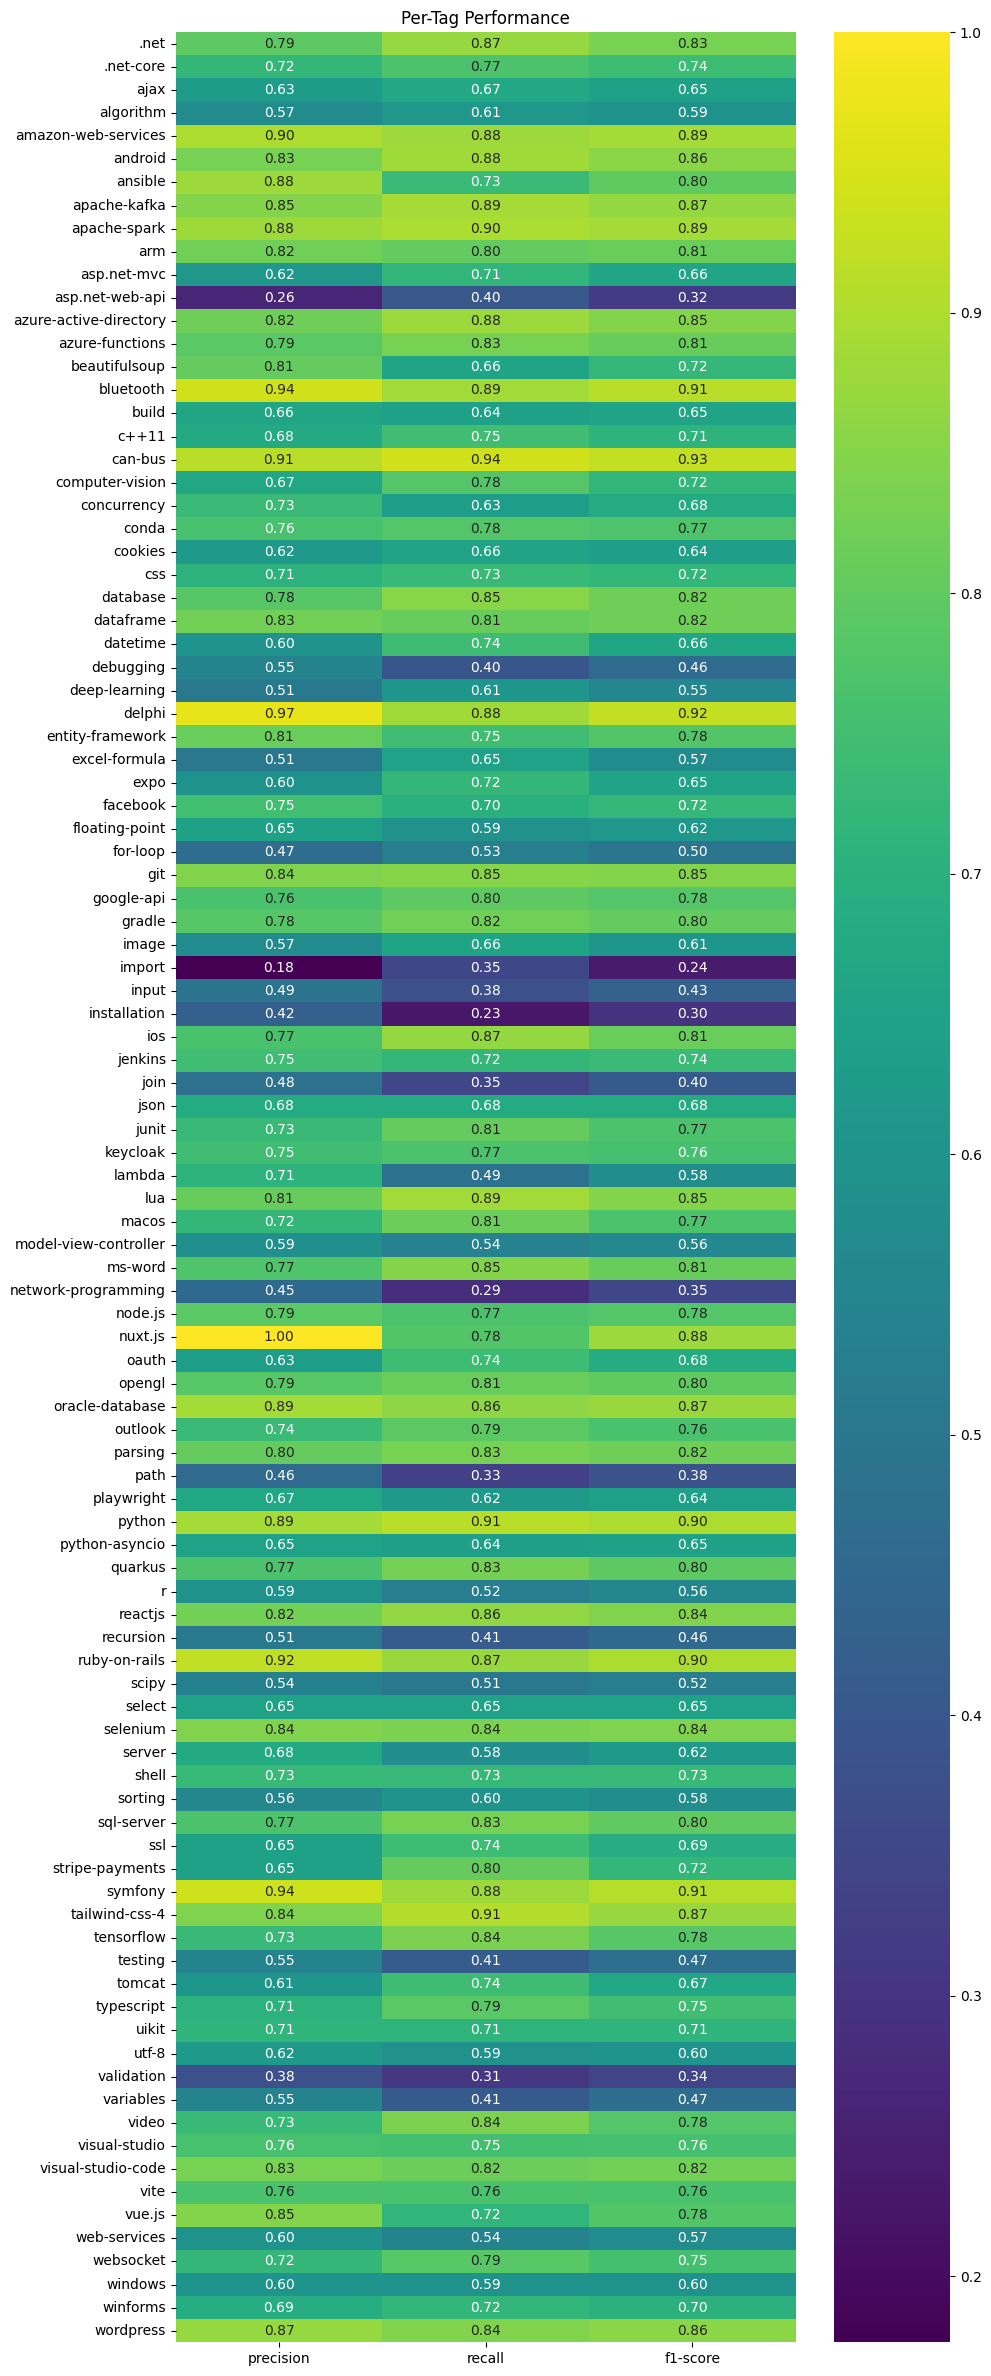

In [13]:
plot_classification_report(val_targets, val_preds, mlb)

In [14]:
import plotly.graph_objects as go

In [15]:
import plotly.subplots as sp

def plot_interactive_confusion_matrix(cm, class_names=None):
    """
    Create an interactive confusion matrix using Plotly for multilabel classification.
    
    Parameters:
    - cm: multilabel confusion matrix (shape: n_classes, 2, 2)
    - class_names: list of class names (optional)
    """
    n_classes = cm.shape[0]
    
    if class_names is None:
        class_names = [f"Class {i}" for i in range(n_classes)]
    
    # Calculate subplot grid
    rows = int(np.ceil(np.sqrt(n_classes)))
    cols = int(np.ceil(n_classes / rows))
    
    fig = sp.make_subplots(
        rows=rows, 
        cols=cols, 
        subplot_titles=class_names[:n_classes],  # Limit to n_classes
        horizontal_spacing=0.05,
        vertical_spacing=0.05
    )
    
    for i in range(n_classes):
        cm_i = cm[i]
        
        # Normalize by row (show percentages)
        cm_normalized = cm_i.astype('float') / cm_i.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero
        
        # Create hover text with both counts and percentages
        hover_text = []
        for p in range(2):
            hover_row = []
            for q in range(2):
                hover_row.append(
                    f"True: {['Negative', 'Positive'][p]}<br>"
                    f"Pred: {['Negative', 'Positive'][q]}<br>"
                    f"Count: {cm_i[p, q]}<br>"
                    f"Percentage: {cm_normalized[p, q]*100:.1f}%"
                )
            hover_text.append(hover_row)
        
        # Add heatmap to subplot
        fig.add_trace(
            go.Heatmap(
                z=cm_normalized,
                x=['Predicted Negative', 'Predicted Positive'],
                y=['True Negative', 'True Positive'],
                hovertext=hover_text,
                hoverinfo='text',
                colorscale='Blues',
                showscale=(i == 0),  # Show colorbar only for the first subplot
                colorbar=dict(title="Percentage") if i == 0 else None
            ),
            row=i // cols + 1,
            col=i % cols + 1
        )
    
    fig.update_layout(
        title='Multilabel Confusion Matrices (Normalized by Row)',
        width=cols * 200,  # Adjust width based on cols
        height=rows * 200,  # Adjust height based on rows
    )
    
    return fig

In [16]:
cm = multilabel_confusion_matrix(val_targets, val_preds)

In [17]:
fig = plot_interactive_confusion_matrix(cm,mlb.classes_)
fig.show()